# Abstract

# Data Exploration

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

# make a copy to use and view that data
df_ = df_train.copy()
df_

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


Lets explore how loan intent varies across age groups

Text(0.5, 1.0, 'Loan Intent by Age')

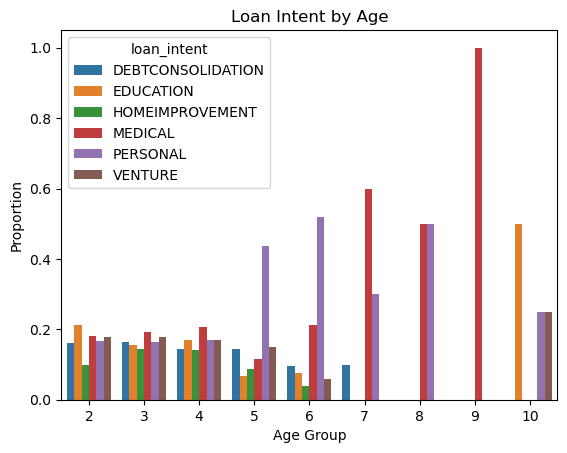

In [36]:
# first lets add a column for age groups
df_["age_group"] = df_["person_age"] // 10
df_["age_group"][df_["age_group"] >= 10 ] = 10

# Get the counts of each loan intent within each age group
loan_intent_counts = df_.groupby("age_group")["loan_intent"].value_counts().unstack()
loan_intent_counts = loan_intent_counts.fillna(0)

# Convert counts to proportions relative to each age group
loan_intent_prop = loan_intent_counts.div(loan_intent_counts.sum(axis=1), axis=0)

# visualize the trends of loan intent and age
temp = pd.melt(loan_intent_prop)

temp["age_group"] = 0 # rebuild the age group category
for i in range(0, len(temp) + 1):
  temp["age_group"][i] = (i % 9) + 2

ax = sns.barplot(data = temp, x = "age_group", y = "value", hue = "loan_intent")
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_title("Loan Intent by Age")

Debt Consolidation is relatively evently represtend between laoners aged 20 - 59, dropping off in the 70 - 79 age group. Education is of course more highly represented in younger loaners, aged 20 - 39, but is also extremely high in loaners of 100+ years old. In the 100+ year old group around 50% of all loans taken out are for Education. Home Improvement is of course more common in younger loaners, aged 20 - 59. Medical loans takes up a larger proportion of loans in older loaners, with 100% of loans in 90 - 99 year olds being for medical reasons. Personal loans are most common in loaners aged 50 - 89, but are still prevalent in younger loaners. Venture is spread evenly throughout all age groups but never eclipses more than 25% of loans. An important trend to notice is that in age groups 2-4 there is a fairly even distribution of all loan intents. Now lets look at how loan size varies by salary.

In [37]:
df_2 = df_train.copy()
df_2["income_cat"] = df_2["person_income"] // 100000

print(df_2.groupby("income_cat")["loan_amnt"].mean().round())

income_cat
0      8835.0
1     13682.0
2     17363.0
3     18957.0
4     19380.0
5     15500.0
6     16340.0
7     13192.0
8      4200.0
9     19150.0
12    10000.0
13     6600.0
14     6400.0
19     1500.0
20     8450.0
60     5000.0
Name: loan_amnt, dtype: float64


While salary (income category) does seem to affect the loan amount, with people having higher salaries taking out larger loans, the higher income categories actually often have lower loan amounts than the lower income categories. This may be a product of people making larger salaries not needing to take out loans as frequently as the middle salaries, which can afford to take out larger loans and pay them back. Let's also determine what factors seem to be related to higher interest rates.

In [38]:
print(df_train.groupby(["loan_int_rate", "loan_grade"]).size())

loan_int_rate  loan_grade
5.42           A             488
5.79           A             304
5.99           A             300
6.00           A               1
               B               3
                            ... 
21.36          F               5
21.74          F               2
22.11          G               2
22.48          G               1
23.22          G               1
Length: 371, dtype: int64


From this snapshot of the larger table, it seems that the high grade loans are associated with the lowest interest rates. Lets explore factors related to loan grades by grouping.

In [39]:
temp = df_train.groupby("loan_grade")[["person_income", "loan_percent_income", "loan_amnt"]].mean()

print(temp)

            person_income  loan_percent_income     loan_amnt
loan_grade                                                  
A            66058.338922             0.154118   8521.577243
B            66230.171995             0.174897   9980.420673
C            65430.863338             0.169796   9236.762722
D            63966.533172             0.190145  10797.149274
E            70110.929215             0.204234  12805.501931
F            77411.340426             0.217979  14759.042553
G            74609.408163             0.230816  16226.020408


As we can see from this datatable, loan grade is directly correlated with lower percent of total income. Meaning that higher quality loans, with lower interest rates are associated with loaners whose loan takes up the smallest percent of their total income. This is likely related to the loan taking up a lower percent of their income making it less likely for them to default on the loan. It also seems to follow that people with higher income tend to take out larger loans.

<Axes: xlabel='person_income', ylabel='loan_amnt'>

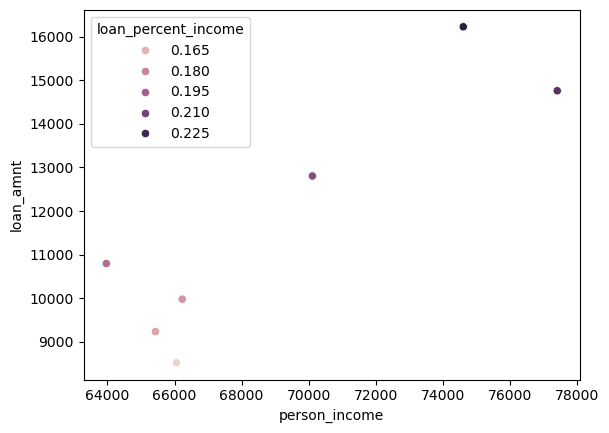

In [40]:
sns.scatterplot(data = temp, x = temp["person_income"], y = "loan_amnt", hue = "loan_percent_income", legend = "brief")

Lower income tends to result in smaller loans, which also take up less percent of loaners total income. The darker shades representing higher percent of total income are associated with lower quality loans. 